# Define beam section geometry and longitudinal reinforcement layout

In [28]:
from math import pi
import matplotlib.pyplot as plt
import numpy as np

f_c_MPa = 30
beam_width_mm = 300
beam_depth_mm = 500
axial_force_kN = -100 # +ve = compression

reinforcement = [
    {"diameter_mm": 20, "yield_strength_MPa": 500, "number": 2, "location_from_top_mm": 75},
    {"diameter_mm": 16, "yield_strength_MPa": 300, "number": 3, "location_from_top_mm": 75},
    {"diameter_mm": 16, "yield_strength_MPa": 300, "number": 5, "location_from_top_mm": 125},
    {"diameter_mm": 16, "yield_strength_MPa": 300, "number": 5, "location_from_top_mm": 350},
    {"diameter_mm": 20, "yield_strength_MPa": 500, "number": 5, "location_from_top_mm": 425},
]


# Define the input variables and constants based on NZS3101:2006 A3 provisions.


In [29]:
modulus_of_elasticity_GPa = 200 # Young`s modulus of steel reinforcement, cl 5.3.4

epsilon_c = -0.003 # maximum concrete strain, cl 7.4.2.3

# Equivalent rectangular concrete stress distribution parameters, cl 7.4.2.7
beta_1 = 0.85 if f_c_MPa <= 30 else max(0.65, 0.85 - 0.008 * ((f_c_MPa - 30))) # eq 7-2
alpha_1 = 0.85 if f_c_MPa <= 55 else max(0.85 - 0.004*(f_c_MPa-55),0.75) # eq 7-3

print(f"for concrete compressive strength of {f_c_MPa} MPa beta_1 = {beta_1} and alpha_1 = {alpha_1}")

for concrete compressive strength of 30 MPa beta_1 = 0.85 and alpha_1 = 0.85


# **Force Equilibrium and Flexural Strength Calculation**
The **"Flexural Capacity"** function below calculates the **force equilibrium** in a **doubly reinforced concrete beam section**, based on general design assumptions for flexural strength outlined in **cl 7.4.2.1 of NZS 3101:2006 A3**.  

### **Key Considerations:**
- It **accounts for compression in concrete**, **tension in reinforcement**, and the **effect of axial load**.
- **Strain compatibility** and **elastic-plastic behavior of steel** are used.
- The output includes:  
  - **Net force imbalance**, aiding in iterative calculations to determine the **neutral axis depth**.  
  - **Moment capacity** from compressive and tensile forces, taken about the **neutral axis**.

### **Beam Parameters:**
- **b** → Beam width (**mm**).  
- **d** → Beam depth (**mm**).  
- **E_s** → Modulus of elasticity of steel (**converted to Pa**).  
- **N** → Axial force (**converted to N**).  

---

In [30]:
b = beam_width_mm
d = beam_depth_mm
E_s = modulus_of_elasticity_GPa * 1000 # convert to Pa
N = axial_force_kN * 1e3 #convert to N

def flexural_capacity(c):
  """
  Calculates the force equilibrium in a doubly reinforced concrete beam section and flexural moment capacity of concrete section
  based on the location of the neutral axis, c.
  """

  a = beta_1 * c # compute equivalent stress block depth
  F_c_concrete = alpha_1 * -1 * f_c_MPa * b * a # compressive force in within concrete compression block
  total_tension_force = 0 # initialise tensile force conntributed by tension reinforcement
  total_moment_reo = 0 # initialise total moment
  forces = [] # create an empty list to append the forces for each reinforcement layer

  # below for lopp iterate over all reinforcement bars in the beam to account for multiple layers or different reinforcement bars
  for reo in reinforcement:
      y = reo["location_from_top_mm"] # the distance from the top of the beam to the centroid of the rebar
      A_s = (pi / 4) * (reo["diameter_mm"] ** 2) * reo["number"] # the area of reinforcement is calculated using the formula for the area of a circle
      f_y = reo["yield_strength_MPa"] # yield strength of the steel rebar
      epsilon_s = epsilon_c * (c - y) / c # strain in reinforcement based on linear strain compatibility (compression strain = -ve)
      f_s = f_y if epsilon_s > f_y / E_s else E_s * epsilon_s # calculate stress in reinforcement based on Hooke's Law
      F_s = A_s * f_s # compute tensile force in each bar (compression = -ve)
      total_tension_force += F_s # compute force difference
      sum_of_forces = F_c_concrete + total_tension_force + N # compute sum of forces
      moment_reo = F_s * (y - c) # calculate moment generated by the reinforcement
      total_moment_reo += moment_reo # sum up the forces in each row of reinforcement
      forces.append((y, F_s)) # append the force in each reinforcement row together with its location from the top of the section
      moment_concrete = F_c_concrete * (a / 2 - c) # moment generated by the concrete force taken about neutral axis
      moment_axial_load = N * (d / 2 - c) # moment generated by the axial load about neutral axis
      M_n = total_moment_reo + moment_concrete + moment_axial_load
      M_n_kNm = M_n / 1e6
  return sum_of_forces, M_n_kNm, F_c_concrete, forces


# Finding the Neutral Axis Depth (𝑐) using the Bisection Method

The bisection method is a numerical approach for finding the root of a function
𝑓(𝑥), meaning it finds 𝑥 where 𝑓(𝑥) = 0
The method works by:


1.   Taking two initial guesses for the lower bound of the interval, $x_{\text{low}}$, and upper bound of the interval, $x_\text{high}$, such that: $$f(x_{\text{low}}) \times f(x_{\text{high}}) < 0$$
     (This ensures that a root exists between them.)
2.   The midpoint is calculated as: $$x_{\text{mid}} = \frac{x_{\text{low}} + x_{\text{high}}}{2}$$
3.   Evaluating the input function at mid point, $f(x_{\text{mid}})$ and updating either $x_{\text{low}}$ or $x_\text{high}$ depending on the sign of $f(x_{\text{mid}})$.
4.   Repeating until the solution converges within the given tolerance (tol)






In [31]:
tolerance = 1e-5 # mm
c_low, c_high = 0.01, d

def bisection_method(func, low, high, tol):
  # format a table headings
  step = 1  # Step counter
  print("Step |    Low    |   High    |    Mid    |  f(Mid)  ")
  print("-" * 50)
  while (high - low) / 2 > tol:
    mid = (low + high) / 2
    f_mid = func(mid)[0]  # Get first output, ignore second
    f_low = func(low)[0]  # Get first output, ignore second
    #  formatted print statement using an f-string in Python to show each step of the iteration
    print(f"{step:3d} | {low:10.4f} | {high:10.4f} | {mid:10.4f} | {f_mid:10.4f}")
    if f_mid == 0:
       return mid  # Found exact root
    elif f_low * f_mid < 0:
       high = mid  # Root is in lower half
    else:
       low = mid  # Root is in upper half
    step += 1   # Increment step counter
  return (low + high) / 2

# Calculate the nominal moment capacity ($M_n$)

Bringing the two functions together, the bisection_method function uses the flexural_capacity function to iterate for the neutral axis.

Refer to the below output for the summary of how the two functions interact.

In [32]:
c = bisection_method(flexural_capacity, c_low, c_high, tolerance)
sum_of_forces, moment_capacity, F_c_concrete, forces = flexural_capacity(c)

print("\n" f"The moment capacity for c = {c} mm is {round(moment_capacity,1)} kNm")
print(f"The compression force in concrete is {round(F_c_concrete,1)} N, \nthe applied axial load is {N} N and \nthe force in each reinforcement layer is {forces}")
print(f"The sum of forces for c = {c} mm is {round(sum_of_forces,1)} N")


Step |    Low    |   High    |    Mid    |  f(Mid)  
--------------------------------------------------
  1 |     0.0100 |   500.0000 |   250.0050 | -1643532.8462
  2 |     0.0100 |   250.0050 |   125.0075 | -121494.0353
  3 |     0.0100 |   125.0075 |    62.5087 | 1029777.2062
  4 |    62.5087 |   125.0075 |    93.7581 | 430489.3402
  5 |    93.7581 |   125.0075 |   109.3828 | 129586.7647
  6 |   109.3828 |   125.0075 |   117.1952 |  -935.9191
  7 |   109.3828 |   117.1952 |   113.2890 | 62951.0110
  8 |   113.2890 |   117.1952 |   115.2421 | 30681.4128
  9 |   115.2421 |   117.1952 |   116.2186 | 14793.2689
 10 |   116.2186 |   117.1952 |   116.7069 |  6909.0547
 11 |   116.7069 |   117.1952 |   116.9510 |  2981.6935
 12 |   116.9510 |   117.1952 |   117.0731 |  1021.6724
 13 |   117.0731 |   117.1952 |   117.1341 |    42.5734
 14 |   117.1341 |   117.1952 |   117.1646 |  -446.7486
 15 |   117.1341 |   117.1646 |   117.1494 |  -202.1065
 16 |   117.1341 |   117.1494 |   117.1418 |   

# **Cross-Section Plot of Reinforced Concrete Beam**
This code generates a **cross-sectional view** of a reinforced concrete beam, displaying the **concrete section and reinforcement bars** with proper labeling.

## **Features:**
✅ **Concrete Section:**
- The **beam's cross-section** is represented as a **light gray rectangle**.  
- The dimensions of the concrete section are **set based on user input** (`b` for width, `d` for depth).  

✅ **Reinforcement Bars:**
- Reinforcement is **grouped by layer** (bars at the same depth).  
- Bars are **evenly spaced** along the beam width.  
- **Alternating bar sizes** are placed **correctly without overlap** when different diameters exist in the same row.  

✅ **Annotations:**
- Each reinforcement layer is labeled with the **number of bars and type**, e.g.:  
  - `"5-HD20"` → **5 bars of 20mm diameter, 500 MPa yield strength**  
  - `"3-D16"` → **3 bars of 16mm diameter, 300 MPa yield strength**  
- **Labels are positioned outside the section** to maintain clarity.  

✅ **Plot Formatting:**
- **Proper aspect ratio (`set_aspect("equal")`)** to ensure an accurate representation.  
- **Bars are drawn in blue** with **semi-transparency (`alpha=0.6`)** for visibility.  

📌 **This visualization provides an engineering-friendly representation of reinforcement placement in a concrete beam.** 🚀


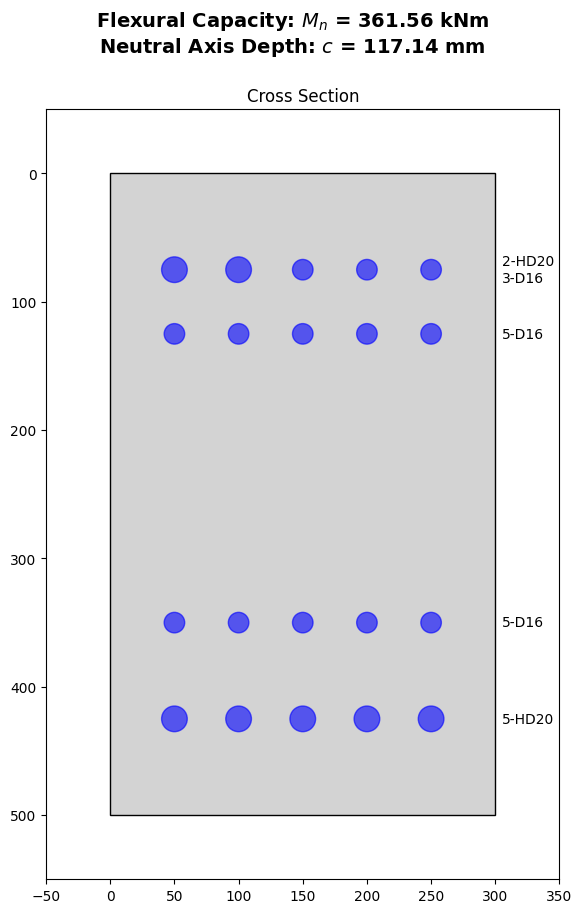

In [33]:
# Create figure and axis
fig, axes = plt.subplots(1, 1, figsize=(8, 10))
plt.suptitle(f"Flexural Capacity: $M_n$ = {moment_capacity:.2f} kNm\nNeutral Axis Depth: $c$ = {c:.2f} mm", fontsize=14, fontweight='bold') # Plot title above all figures

# Plot Concrete Section
axes.set_xlim(-50, b + 50)
axes.set_ylim(d + 50, -50)
axes.set_title("Cross Section")

# Draw the concrete section
rect = plt.Rectangle((0, 0), b, d, linewidth=1, edgecolor='black', facecolor='lightgray')
axes.add_patch(rect)

# Group bars by layer
layer_bars = {}
for reo in reinforcement:
    y = reo["location_from_top_mm"]
    if y not in layer_bars:
        layer_bars[y] = []
    layer_bars[y].append(reo)

# Draw reinforcement bars with alternating positions
for y, bars in layer_bars.items():
    total_bars = sum(bar["number"] for bar in bars)
    x_positions = np.linspace(50, b - 50, total_bars)  # Evenly spread bars

    pos_index = 0
    layer_labels = []
    for bar in bars:
        label = f"{bar['number']}-HD{bar['diameter_mm']}" if bar["yield_strength_MPa"] == 500 else f"{bar['number']}-D{bar['diameter_mm']}"
        if label not in layer_labels:
            layer_labels.append(label)

        for _ in range(bar["number"]):
            x = x_positions[pos_index]
            axes.add_patch(plt.Circle((x, y), bar["diameter_mm"] / 2, color='blue', alpha=0.6))
            pos_index += 1

    # Annotate row with combined labels
    combined_label = "\n".join(layer_labels)
    axes.text(b + 5, y, combined_label, fontsize=10, verticalalignment='center')

plt.gca().set_aspect('equal')
plt.show()

# **Strain Diagram with Reinforcement and Neutral Axis Annotation**
This code generates a **strain diagram** for a reinforced concrete section, including:
- **Strain distribution curve** (blue line)  
- **Concrete strain region** (shaded blue)  
- **Reinforcement strain lines** (green dashed)  
- **Concrete strain at the top fiber** (red dashed)  
- **Neutral axis** (black dashed vertical line)  

### **Additional Features:**
✅ **Strain Annotations:** Each reinforcement layer is labeled with its strain value and depth (e.g., `-0.0025 at 125mm`).  
✅ **Neutral Axis Dimension Line:**  
  - A **vertical dimension line** (black `<->` arrow) positioned slightly to the **right** of the neutral axis.  
  - A **rotated (90° counterclockwise) label** displaying `c = XX.XX mm`.  
✅ **Legend for clarity**, showing:  
  - "Strain Distribution"  
  - "Concrete Strain"  
  - "Reinforcement Strain"  
  - "Concrete Strain at Top"  
  - "Neutral Axis"  

### **Visual Improvements:**
- **Y-axis is inverted** (`0mm` at the top, depth increases downward).  
- **Annotations are placed strategically** to prevent overlapping.  

📌 **This plot provides a clear, engineering-friendly visualization of strain distribution in reinforced concrete.** 🚀


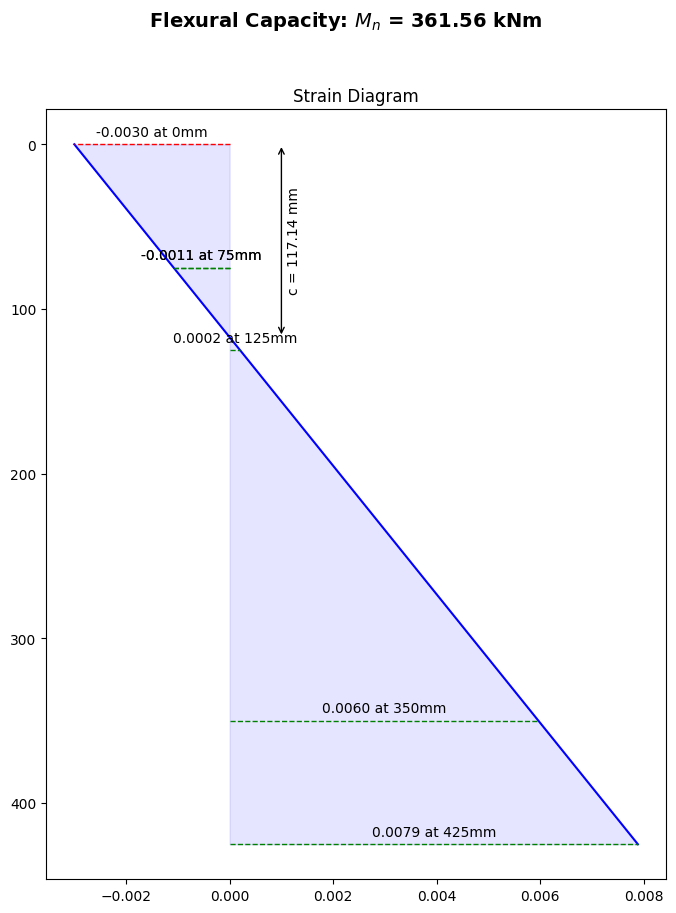

In [41]:
# Create figure and axis
fig, axes = plt.subplots(1, 1, figsize=(8, 10))
plt.suptitle(f"Flexural Capacity: $M_n$ = {moment_capacity:.2f} kNm", fontsize=14, fontweight='bold') # Plot title above all figures

max_reo_depth = max(reo["location_from_top_mm"] for reo in reinforcement)
depths = np.linspace(0, max_reo_depth, 100)
strains = [epsilon_c * (c - y) / c for y in depths]

axes.plot(strains, depths, color='blue', label="Strain Distribution")
axes.fill_betweenx(depths, 0, strains, color='blue', alpha=0.1, label="Concrete Strain")

for reo in reinforcement:
    y = reo["location_from_top_mm"]
    epsilon_s = epsilon_c * (c - y) / c
    axes.hlines(y=y, xmin=0, xmax=epsilon_s, color='green', linestyle="--", linewidth=1, label="Reinforcement Strain")

    # Add annotation centered above the line
    axes.text(epsilon_s / 2, y - 5, f"{epsilon_s:.4f} at {y}mm",
              fontsize=10, color="black", horizontalalignment='center')

axes.hlines(y=0, xmin=0, xmax=epsilon_c, color='red', linestyle="--", linewidth=1, label="Concrete compression strain")

# Annotation for top strain
axes.text(epsilon_c / 2, -5, f"{epsilon_c:.4f} at 0mm",
          fontsize=10, color="black", horizontalalignment='center')

axes.set_title("Strain Diagram")

# Invert y-axis so 0mm is at the top
axes.invert_yaxis()

# Position dimension line slightly to the right of the neutral axis
dim_x = 0.001  # Small positive offset for visibility

axes.annotate("", xy=(dim_x, c), xytext=(dim_x, 0),
              arrowprops=dict(arrowstyle="<->", color="black", linewidth=1))

# Add label for neutral axis depth, rotated 90° counterclockwise
axes.text(dim_x + 0.0001, c / 2, f"c = {c:.2f} mm", fontsize=10, color="black",
          verticalalignment="center", horizontalalignment="left", rotation=90)

plt.show()

# **Stress Diagram for Reinforced Concrete Beam**  

This code **plots the stress distribution** in a **doubly reinforced concrete section** subjected to bending. It calculates the **stress in concrete and reinforcement** based on strain compatibility and material properties.  

## **🔹 Key Features**  

### **1️⃣ Concrete Stress Block**  
✅ The **equivalent stress block depth** is computed as:  
`a = β₁ * c`  

✅ The **compressive stress in concrete** is plotted:  
- **Blue solid line & filled region** → Represents the **compression stress block**  
- **Concrete stress is constant (-f_c) up to depth a**  

### **2️⃣ Reinforcement Stress Representation**  
✅ **Stress in each reinforcement layer** is computed using:  
✅ **Green dashed lines** represent **reinforcement stress** at various depths  
✅ **Annotations** display stress values at each reinforcement layer  

### **3️⃣ Dimension & Annotations**  
✅ A **dimension line** marks the depth of the **compression block (a)**  
✅ **Label "a" is rotated 90° counterclockwise** for clarity  
✅ **Red dashed line at y = 0 mm** represents the extreme **compression fiber**  
✅ **Black vertical dashed line at x = 0** serves as the **neutral axis reference**  

## **📌 Axis Formatting**  
✔ **Inverted y-axis** so that **0 mm is at the top** (consistent with engineering drawings)  


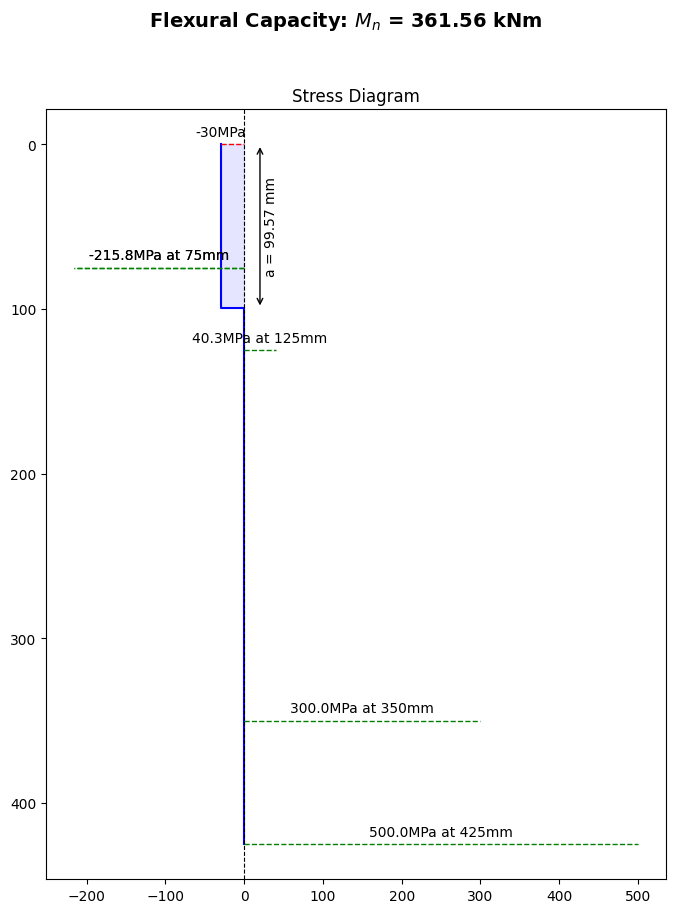

In [35]:
# Create figure and axis
fig, axes = plt.subplots(1, 1, figsize=(8, 10))
plt.suptitle(f"Flexural Capacity: $M_n$ = {moment_capacity:.2f} kNm", fontsize=14, fontweight='bold') # Plot title above all figures

# Plot Stress Diagram
a = beta_1 * c # compute equivalent stress block depth
stress_x = [-f_c_MPa, -f_c_MPa, 0, 0]
stress_y = [0, a, a, max_reo_depth]

axes.plot(stress_x, stress_y, color='blue', label="Stress (MPa)")
axes.fill_betweenx([0, a], -f_c_MPa, 0, color='blue', alpha=0.1)

for reo in reinforcement:
  y = reo["location_from_top_mm"]
  epsilon_s = epsilon_c * (c - y) / c
  f_s = reo["yield_strength_MPa"] if epsilon_s > reo["yield_strength_MPa"] / E_s else E_s * epsilon_s
  axes.hlines(y=y, xmin=0, xmax=f_s, color='green', linestyle="--", linewidth=1)
  axes.text(f_s / 2, y - 5, f"{f_s:.1f}MPa at {y}mm", fontsize=10, color="black", horizontalalignment='center')

# Annotation for concrete stress
axes.text(-f_c_MPa, -5, f"{-f_c_MPa}MPa",
          fontsize=10, color="black", horizontalalignment='center')

dim_x = 20  # Small positive offset for visibility
axes.annotate("", xy=(dim_x, a), xytext=(dim_x, 0),
              arrowprops=dict(arrowstyle="<->", color="black", linewidth=1))

# Add label for compression block depth, rotated 90° counterclockwise
axes.text(dim_x + 5, a / 2, f"a = {a:.2f} mm", fontsize=10, color="black",
          verticalalignment="center", horizontalalignment="left", rotation=90)

axes.hlines(y=0, xmin=-f_c_MPa, xmax=0, color='red', linestyle="--", linewidth=1)
axes.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
axes.set_title("Stress Diagram")
# Invert y-axis so 0mm is at the top
axes.invert_yaxis()

# **Force Diagram Visualization in Python**

This python code generates a force diagram for reinforcement forces and concrete compression force.  

✅ This script visualizes reinforcement and concrete compression forces in a structural element.  
✅ It aggregates forces at the same location.  
✅ Forces are represented as arrows with labels.  
✅ The neutral axis is shown as a reference.  
✅ The final diagram provides a clear force distribution overview.

## **🔹 Key Features**  
### **1️⃣ Import Required Libraries**
We need `matplotlib.pyplot` for plotting and `defaultdict` from `collections` to sum forces at the same location.

### **2️⃣ Define Input Data**
The reinforcement forces and concrete compression force are defined in Newtons (N).  
These forces act at different positions along the structural element.

### **3️⃣ Aggregate Forces at the Same Location**
Since multiple forces may be applied at the same `y` position, we sum them using a dictionary (`defaultdict`).

### **4️⃣ Create the Force Diagram**
We use `matplotlib` to plot the forces as arrows, representing their magnitude and position.

### **5️⃣ Plot the Reinforcement Forces**
Each reinforcement force is converted from Newtons (N) to kilonewtons (kN) and displayed as an arrow.

### **6️⃣ Plot the Concrete Compression Force**
The concrete compression force is plotted separately in red.

### **7️⃣ Add Reference Lines and Adjust Axis**
We add a dashed vertical line to indicate the neutral axis and invert the y-axis to align with standard structural diagrams.

### **8️⃣ Display the Diagram**
Finally, we use `plt.show()` to display the diagram.

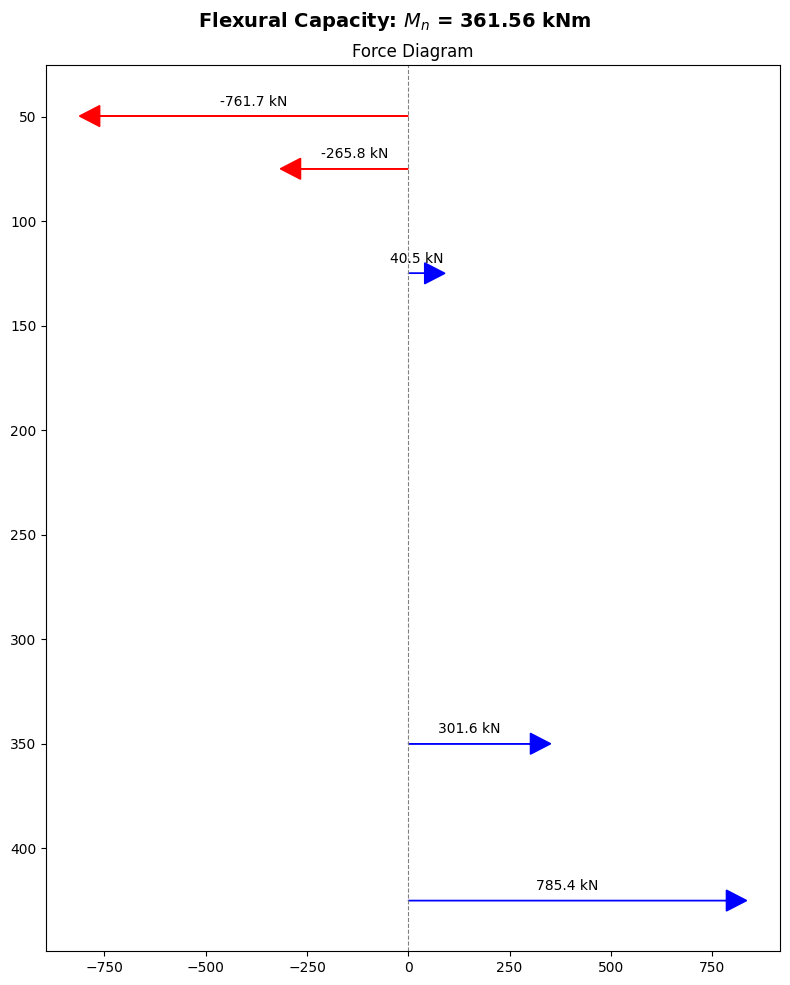

In [39]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Aggregate forces at the same y location
force_dict = defaultdict(float)
for y, F in forces:
    force_dict[y] += F  # Sum forces at the same y position

# Create figure and axis
fig, axes = plt.subplots(1, 1, figsize=(8, 10))
plt.suptitle(f"Flexural Capacity: $M_n$ = {moment_capacity:.2f} kNm", fontsize=14, fontweight='bold')
axes.set_title("Force Diagram")

# Plot reinforcement forces
for (y, F) in force_dict.items():
    F_kN = F / 1000  # Convert N to kN
    color = 'red' if F_kN < 0 else 'blue'  # Use red for negative forces
    axes.arrow(0, y, F_kN, 0, head_width=10, head_length=50, color=color)
    axes.text(F_kN / 2, y - 5, f"{F_kN:.1f} kN", fontsize=10, color="black", horizontalalignment='center')

# Plot concrete compression force
F_c_kN = F_c_concrete / 1000  # Convert N to kN
axes.arrow(0, a / 2, F_c_kN, 0, head_width=10, head_length=50, color='red')
axes.text(F_c_kN / 2, a / 2 - 5, f"{F_c_kN:.1f} kN", fontsize=10, color="black", horizontalalignment='center')

# Vertical neutral axis reference line
axes.axvline(x=0, color="grey", linestyle="--", linewidth=0.8)

# Invert y-axis so 0mm is at the top
axes.invert_yaxis()

plt.tight_layout()
plt.show()


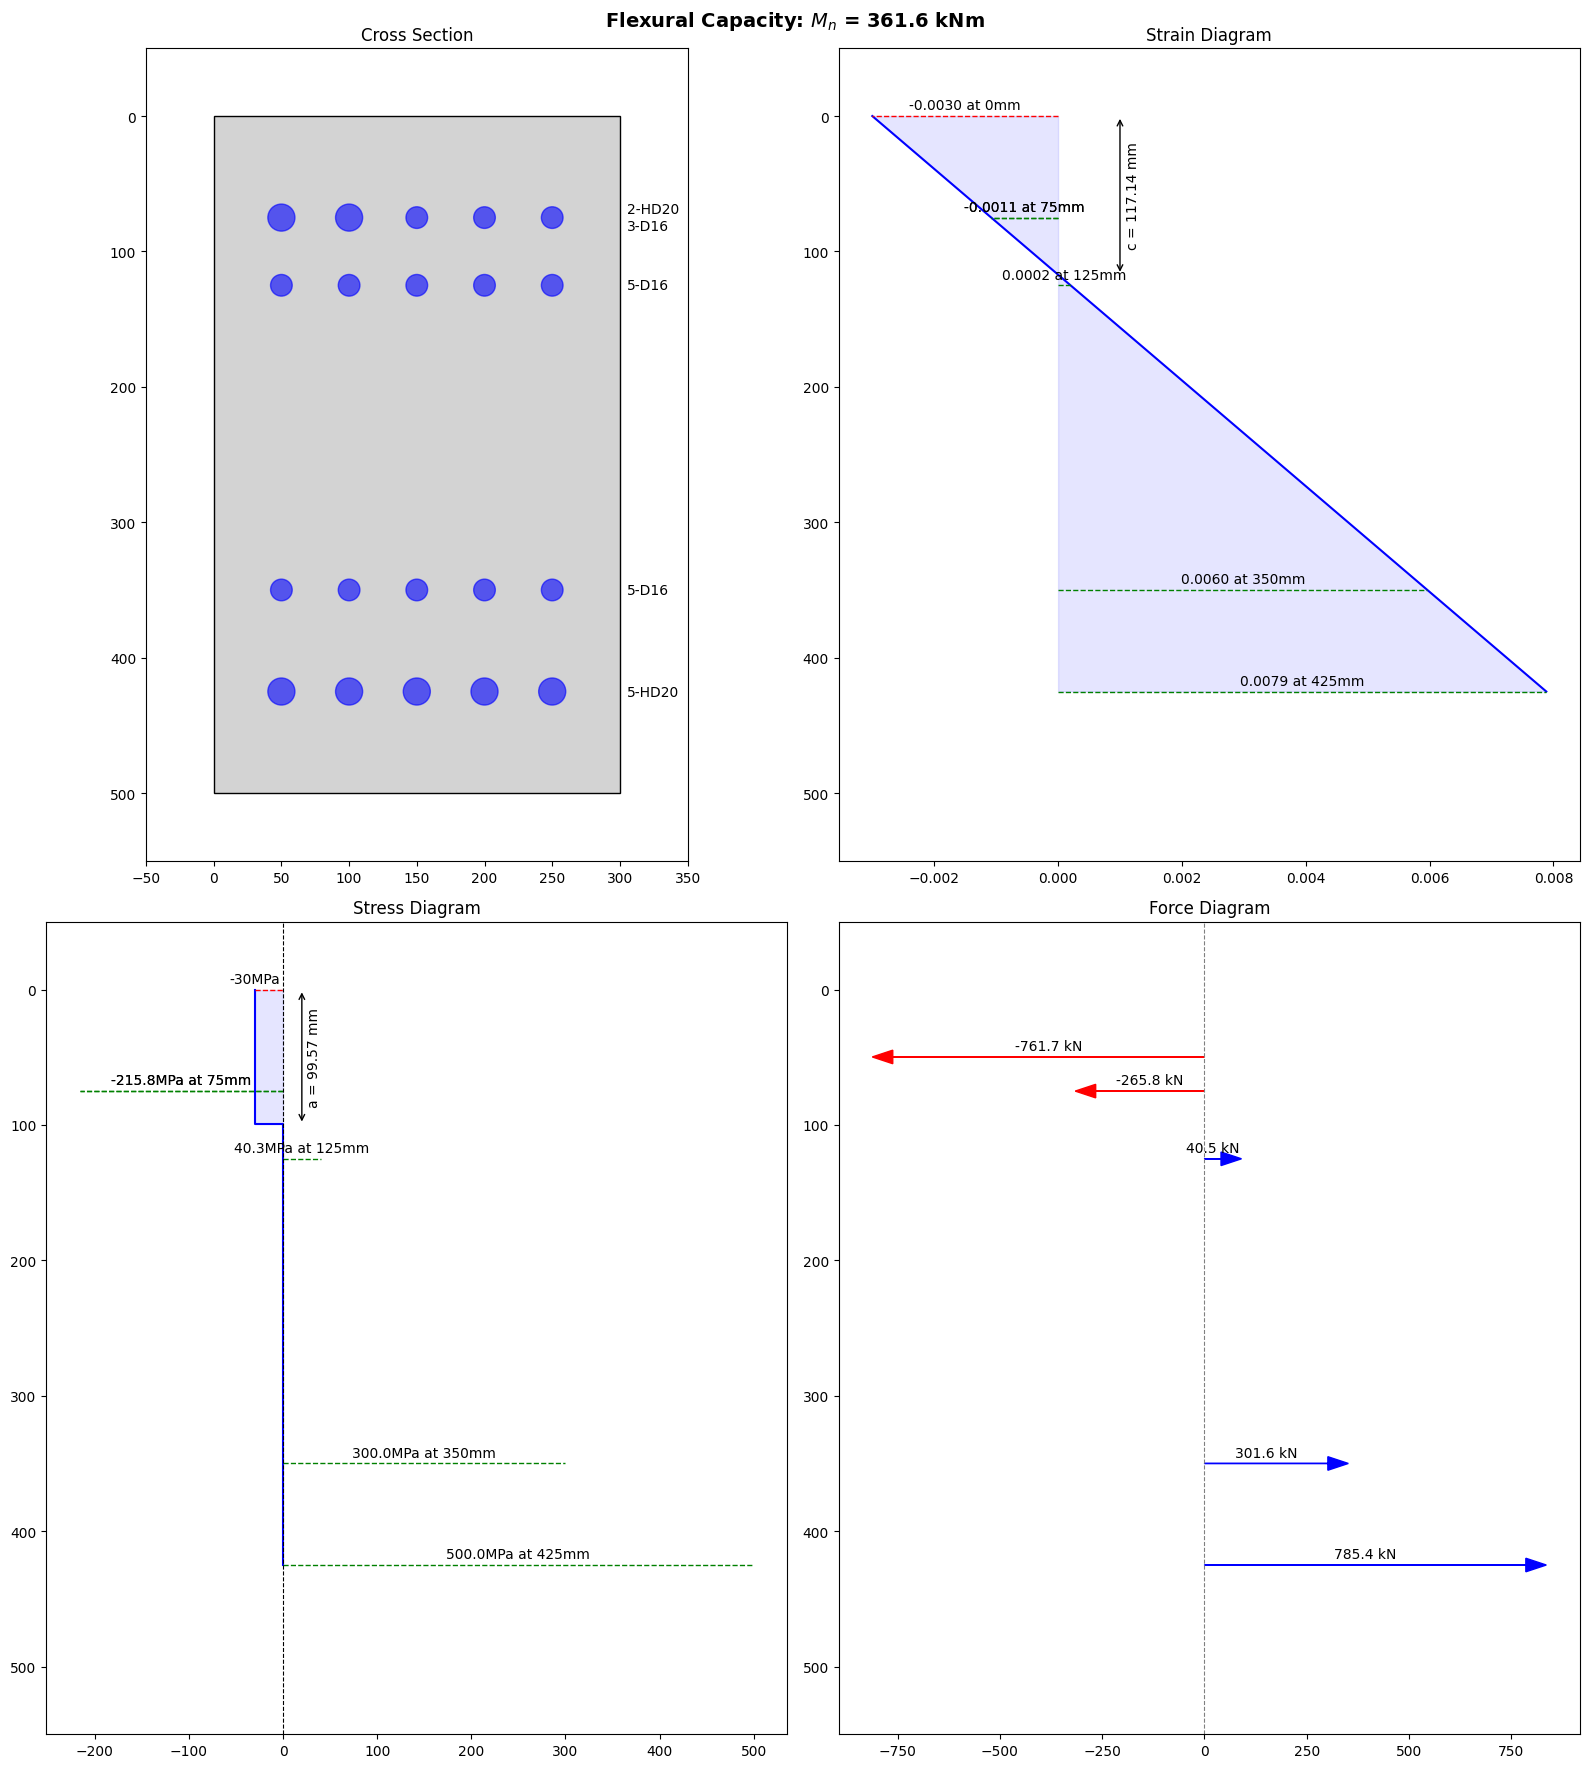

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Create a shared figure and axes
fig, axes = plt.subplots(2, 2, figsize=(16, 18))  # 2x2 grid for four subplots
plt.suptitle(f"Flexural Capacity: $M_n$ = {moment_capacity:.1f} kNm",
             fontsize=14, fontweight='bold')

# Set common y-axis limit
y_limit = [max(d + 50, max_reo_depth), -50]  # Set y-axis based on the maximum depth

# Cross Section Plot (top-left)
axes[0, 0].set_xlim(-50, b + 50)
axes[0, 0].set_ylim(y_limit)
axes[0, 0].set_title("Cross Section")

# Draw the concrete section
rect = plt.Rectangle((0, 0), b, d, linewidth=1, edgecolor='black', facecolor='lightgray')
axes[0, 0].add_patch(rect)

# Group bars by layer
layer_bars = {}
for reo in reinforcement:
    y = reo["location_from_top_mm"]
    if y not in layer_bars:
        layer_bars[y] = []
    layer_bars[y].append(reo)

# Draw reinforcement bars with alternating positions
for y, bars in layer_bars.items():
    total_bars = sum(bar["number"] for bar in bars)
    x_positions = np.linspace(50, b - 50, total_bars)  # Evenly spread bars

    pos_index = 0
    layer_labels = []
    for bar in bars:
        label = f"{bar['number']}-HD{bar['diameter_mm']}" if bar["yield_strength_MPa"] == 500 else f"{bar['number']}-D{bar['diameter_mm']}"
        if label not in layer_labels:
            layer_labels.append(label)

        for _ in range(bar["number"]):
            x = x_positions[pos_index]
            axes[0, 0].add_patch(plt.Circle((x, y), bar["diameter_mm"] / 2, color='blue', alpha=0.6))
            pos_index += 1

    # Annotate row with combined labels
    combined_label = "\n".join(layer_labels)
    axes[0, 0].text(b + 5, y, combined_label, fontsize=10, verticalalignment='center')

axes[0, 0].set_aspect('equal')

# Strain Diagram Plot (top-right)
axes[0, 1].set_ylim(y_limit)
axes[0, 1].set_title("Strain Diagram")

max_reo_depth = max(reo["location_from_top_mm"] for reo in reinforcement)
depths = np.linspace(0, max_reo_depth, 100)
strains = [epsilon_c * (c - y) / c for y in depths]

axes[0, 1].plot(strains, depths, color='blue', label="Strain Distribution")
axes[0, 1].fill_betweenx(depths, 0, strains, color='blue', alpha=0.1, label="Concrete Strain")

for reo in reinforcement:
    y = reo["location_from_top_mm"]
    epsilon_s = epsilon_c * (c - y) / c
    axes[0, 1].hlines(y=y, xmin=0, xmax=epsilon_s, color='green', linestyle="--", linewidth=1, label="Reinforcement Strain")
    axes[0, 1].text(epsilon_s / 2, y - 5, f"{epsilon_s:.4f} at {y}mm", fontsize=10, color="black", horizontalalignment='center')

axes[0, 1].hlines(y=0, xmin=0, xmax=epsilon_c, color='red', linestyle="--", linewidth=1, label="Concrete compression strain")
axes[0, 1].text(epsilon_c / 2, -5, f"{epsilon_c:.4f} at 0mm", fontsize=10, color="black", horizontalalignment='center')

# Neutral axis dimension annotation
dim_x = 0.001  # Small positive offset for visibility
axes[0, 1].annotate("", xy=(dim_x, c), xytext=(dim_x, 0), arrowprops=dict(arrowstyle="<->", color="black", linewidth=1))
axes[0, 1].text(dim_x + 0.0001, c / 2, f"c = {c:.2f} mm", fontsize=10, color="black", verticalalignment="center", horizontalalignment="left", rotation=90)

# Stress Diagram Plot (bottom-left)
axes[1, 0].set_ylim(y_limit)
axes[1, 0].set_title("Stress Diagram")

a = beta_1 * c # compute equivalent stress block depth
stress_x = [-f_c_MPa, -f_c_MPa, 0, 0]
stress_y = [0, a, a, max_reo_depth]

axes[1, 0].plot(stress_x, stress_y, color='blue', label="Stress (MPa)")
axes[1, 0].fill_betweenx([0, a], -f_c_MPa, 0, color='blue', alpha=0.1)

for reo in reinforcement:
    y = reo["location_from_top_mm"]
    epsilon_s = epsilon_c * (c - y) / c
    f_s = reo["yield_strength_MPa"] if epsilon_s > reo["yield_strength_MPa"] / E_s else E_s * epsilon_s
    axes[1, 0].hlines(y=y, xmin=0, xmax=f_s, color='green', linestyle="--", linewidth=1)
    axes[1, 0].text(f_s / 2, y - 5, f"{f_s:.1f}MPa at {y}mm", fontsize=10, color="black", horizontalalignment='center')

axes[1, 0].text(-f_c_MPa, -5, f"{-f_c_MPa}MPa", fontsize=10, color="black", horizontalalignment='center')

dim_x = 20  # Small positive offset for visibility
axes[1, 0].annotate("", xy=(dim_x, a), xytext=(dim_x, 0), arrowprops=dict(arrowstyle="<->", color="black", linewidth=1))
axes[1, 0].text(dim_x + 5, a / 2, f"a = {a:.2f} mm", fontsize=10, color="black", verticalalignment="center", horizontalalignment="left", rotation=90)

axes[1, 0].hlines(y=0, xmin=-f_c_MPa, xmax=0, color='red', linestyle="--", linewidth=1)
axes[1, 0].axvline(x=0, color="black", linestyle="--", linewidth=0.8)

# Force Diagram Plot (bottom-right)
axes[1, 1].set_ylim(y_limit)
axes[1, 1].set_title("Force Diagram")

# Aggregate forces at the same y location
force_dict = defaultdict(float)
for y, F in forces:
    force_dict[y] += F  # Sum forces at the same y position

# Plot reinforcement forces
for (y, F) in force_dict.items():
    F_kN = F / 1000  # Convert N to kN
    color = 'red' if F_kN < 0 else 'blue'  # Use red for negative forces
    axes[1, 1].arrow(0, y, F_kN, 0, head_width=10, head_length=50, color=color)
    axes[1, 1].text(F_kN / 2, y - 5, f"{F_kN:.1f} kN", fontsize=10, color="black", horizontalalignment='center')

# Plot concrete compression force
F_c_kN = F_c_concrete / 1000  # Convert N to kN
axes[1, 1].arrow(0, a / 2, F_c_kN, 0, head_width=10, head_length=50, color='red')
axes[1, 1].text(F_c_kN / 2, a / 2 - 5, f"{F_c_kN:.1f} kN", fontsize=10, color="black", horizontalalignment='center')

# Vertical neutral axis reference line
axes[1, 1].axvline(x=0, color="grey", linestyle="--", linewidth=0.8)

plt.tight_layout()
plt.show()
